In [1]:
import pandas as pd
import requests
from pprint import pprint
import datetime

In [2]:
appid = 24780  

# Open a file to write the scraped data
with open("reviews_simcity4_extended.csv", "w+", encoding='utf-8') as fo:
    # Write the header for the CSV file
    print("review,author_vote,other_votes,weighted_vote_score,votes_funny,comment_count,timestamp_created,playtime_at_review", file=fo)

    cursor = '*'  # Start with the initial cursor
    base_url = f'https://store.steampowered.com/appreviews/{appid}'

    curr_page = 0 # Initialize the current page counter
    while True:
        # Set the parameters for the API request
        params = { # https://partner.steamgames.com/doc/store/getreviews
            'json' : 1,
            'filter' : 'all', # sort by: recent, updated, all (helpfulness)
            'language' : 'english', # https://partner.steamgames.com/doc/store/localization # Onlu fetch reviews in English
            'day_range' : 9223372036854775807, # shows reviews from all time 
            'review_type' : 'all', # include all reviews (positive and negative)
            'purchase_type' : 'all', # all, non_steam_purchase, steam
            'num_per_page' : 100, # Number of reviews per page
            'cursor': cursor,  # Use the cursor returned from the last request
        }
        response = requests.get(base_url, params=params) #Make the API request
        data = response.json() # Parse the JSON response

        print(curr_page, end=" ") # Print the current page number
        curr_page += 1 # Increment the current page counter

        # Break the loop if there are no more reviews
        if 'reviews' in data and not data['reviews']:
            break
        
        page_list = data['reviews'] # Get the list of reviews from the response

        for i, page in enumerate(page_list):
            words =  page["review"].split() # Split the review text into words

            if len(words) < 30: 
                continue # Skip reviews with less than 30 words
            
            # Prepare the review text for CSV
            rev = '"' + page["review"].replace('"',"") + '"'
            author_vote = 1 if page['voted_up'] else 0 # Convert voted_up to binary
            other_votes = page['votes_up']
            weighted_vote_score = page["weighted_vote_score"] 
            votes_funny = page["votes_funny"] # Get votes_funny or default to 0
            comment_count = page["comment_count"] # Get comment_count or default to 0
            timestamp_created = datetime.datetime.fromtimestamp(page["timestamp_created"]).strftime('%Y-%m-%d %H:%M:%S') # Convert timestamp to human-readable format
            playtime_at_review = page["author"].get("playtime_at_review", 0) #Get playtime_at_review or default to 0

            # Write the extracted data to the CSV file
            print(rev, ',', author_vote, ',', other_votes, ',', weighted_vote_score, ',', votes_funny, ',', comment_count, ',', timestamp_created, ',', playtime_at_review, file=fo)

        # Update the cursor for the next API request
        cursor = data['cursor']

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 

In [3]:
%pip install nltk --upgrade


[notice] A new release of pip is available: 23.2.1 -> 24.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Using the SentiWordNet lexicon instead of VADER
import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
import pandas as pd

# Download the SentiWordNet and WordNet resources
nltk.download('sentiwordnet');
nltk.download('wordnet');
nltk.download('averaged_perceptron_tagger');
nltk.download('punkt')

[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /Users/karakaya/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/karakaya/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/karakaya/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /Users/karakaya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
def get_sentiment(word, pos):
    synsets = list(swn.senti_synsets(word, pos))
    if not synsets:
        return 0, 0, 0
    synset = synsets[0]
    return synset.pos_score(), synset.neg_score(), synset.obj_score()

def sentiment_analysis_SentiWordNet(sentence):
    tokens = nltk.word_tokenize(sentence)
    pos_tags = nltk.pos_tag(tokens)
    sentiment_scores = {'positive': 0, 'negative': 0, 'objective': 0 }
    word_count = 0

    for word, tag in pos_tags:
        wn_tag = get_wordnet_pos(tag)

        if wn_tag is not None:
            print(f"{word}={wn_tag}", end=", ")
            pos_score, neg_score, obj_score = get_sentiment(word, wn_tag)
            sentiment_scores['positive'] += pos_score
            sentiment_scores['negative'] += neg_score
            sentiment_scores['objective'] += obj_score
            word_count += 1

    # Normalize the score by the number of words
    if word_count > 0:
        sentiment_scores['positive'] /= word_count
        sentiment_scores['negative'] /= word_count
        sentiment_scores['objective'] /= word_count

    return sentiment_scores['positive'], sentiment_scores['negative'], sentiment_scores['objective'], word_count

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wn.ADJ
    elif treebank_tag.startswith('V'):
        return wn.VERB
    elif treebank_tag.startswith('N'):
        return wn.NOUN
    elif treebank_tag.startswith('R'):
        return wn.ADV
    else:
        return None

In [8]:
# Read the CSV file
file_name = 'reviews_simcity4_extended.csv'
df = pd.read_csv(file_name)

reviews = df['review'].tolist()

# Perform sentiment analysis on each review
results = []

for review in reviews:
    pos_score, neg_score, obj_score, word_count = sentiment_analysis_SentiWordNet(review)
    results.append({
        'review': review,
        'positive_score': pos_score,
        'negative_score': neg_score,
        'objective_score': obj_score,
        'word_count': word_count
    })

# Convert the results to a DataFrame for better readability
results_df = pd.DataFrame(results)

# Print the results
print(results_df)





people=n, do=v, n't=r, know=v, PC=n, Gaming=n, Wiki=n, is=v, here=r, are=v, essential=a, files=n, need=v, download=v, apply=v, game=n, get=v, best=a, experience=n, SimCity=n, modern=a, operating=v, systems=n, Large=a, Address=n, Hardware=n, improves=v, games=n, performance=n, removing=v, limit=n, much=a, RAM=n, SimCity=n, is=v, allowed=v, use=v, https=n, //www.techpowerup.com/forums/threads/large-address-aware.112556/=a, SC4Fix=n, .dll=a, file=n, fixes=v, bugs=n, unpatched=v, Maxis=n, crash=n, issues=n, infamous=a, prop=n, pox=n, glitch=n, general=a, gradually=r, removes=v, props=n, player=n, city=n, breaking=v, game=n, https=n, //community.simtropolis.com/files/file/30883-sc4fix-third-party-patches-for-sc4/=a, SimCity=n, Launcher=n, launcher=n, game=n, includes=v, options=n, autosave=n, choices=n, renderers=n, CPU=n, improvements=n, widescreen=a, resolutions=n, borderless=n, not=r, borderless=a, windows=n, mod=n, manager=n, tick=n, disable=v, intro=a, movies=n, improvement=n, forces=v

In [ ]:
# Perform descriptive statistics, using the describe() method from pandas to compute descriptive statistics (mean, standard deviation, min, max, etc.) for the sentiment scores and word count.
#descriptive_stats = results_df.describe()
#print(descriptive_stats)

# Perform descriptive statistics on the combined DataFrame
#descriptive_stats = combined_df.describe(include='all')
#print(descriptive_stats)

# Combine the original DataFrame with the sentiment analysis results
combined_df = pd.concat([df, results_df.drop(columns='review')], axis=1)

# Print the combined DataFrame
# print(combined_df)

# Perform descriptive statistics on the combined DataFrame
# descriptive_stats = combined_df.describe(include='all')
# print(descriptive_stats)

In [9]:
# Load the CSV file
file_name = 'reviews_simcity4_extended.csv'
df = pd.read_csv(file_name)

# Display the first few rows of the dataset
print(df.head())

# Display basic information about the dataset
print(df.info())

# Display summary statistics of the dataset
print(df.describe(include='all'))

                                              review  author_vote  \
0  Since people don't know what the PC Gaming Wik...            1   
1  Doesn't require a constant internet connection...            1   
2  I played this game a lot when i was 12 or 13 o...            1   
3  If modded this game even though its ten years ...            1   
4  Everyone is right, it really is still the best...            1   

   other_votes  weighted_vote_score  votes_funny  comment_count  \
0          312             0.962180            4             15   
1         1235             0.957100          241             20   
2         1429             0.949670          113             39   
3          287             0.942572           12             15   
4          137             0.923562            0              0   

       timestamp_created  playtime_at_review  
0   2019-10-04 16:37:39                   79  
1   2014-11-26 16:30:17                 4303  
2   2013-07-05 05:55:15                  

In [10]:
# Check for missing values
print(df.isnull().sum())

review                 0
author_vote            0
other_votes            0
weighted_vote_score    0
votes_funny            0
comment_count          0
timestamp_created      0
playtime_at_review     0
dtype: int64


In [11]:
# Display the data types of each column
print(df.dtypes)

review                  object
author_vote              int64
other_votes              int64
weighted_vote_score    float64
votes_funny              int64
comment_count            int64
timestamp_created       object
playtime_at_review       int64
dtype: object


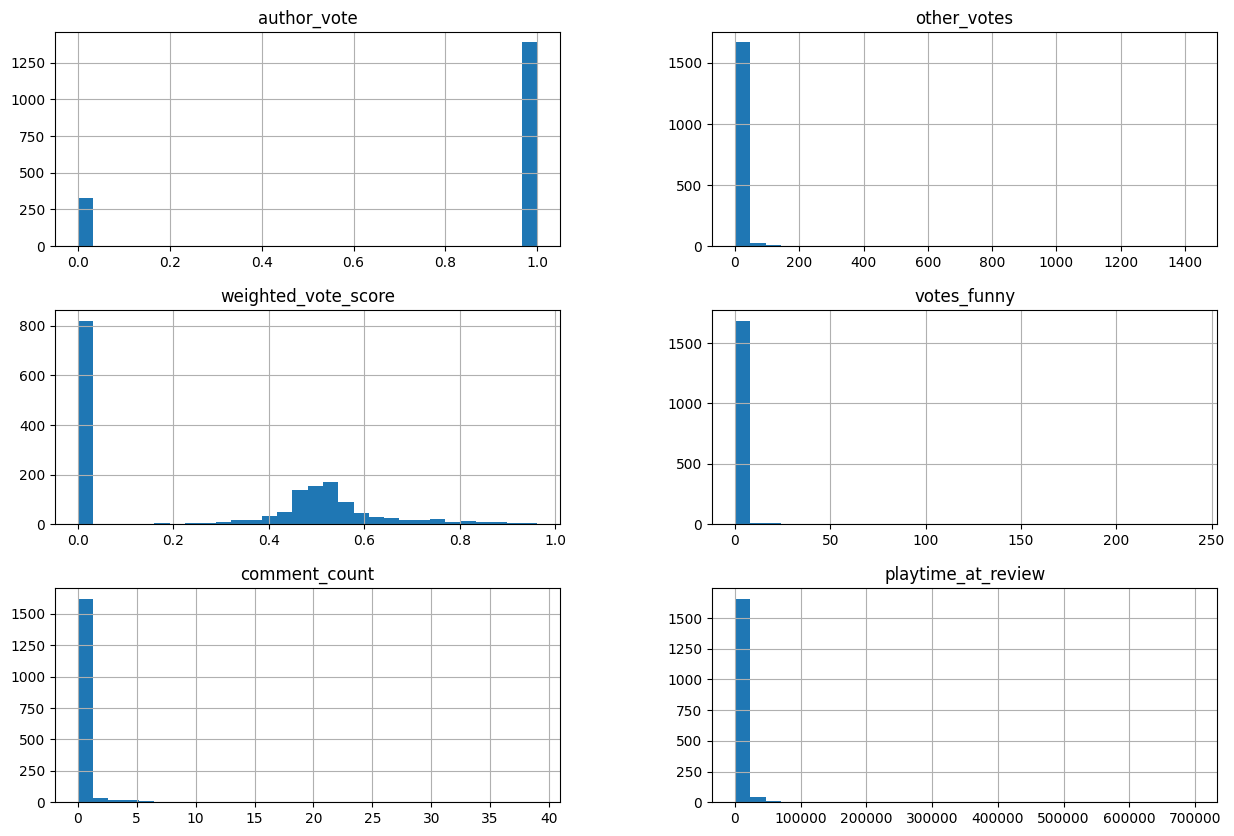

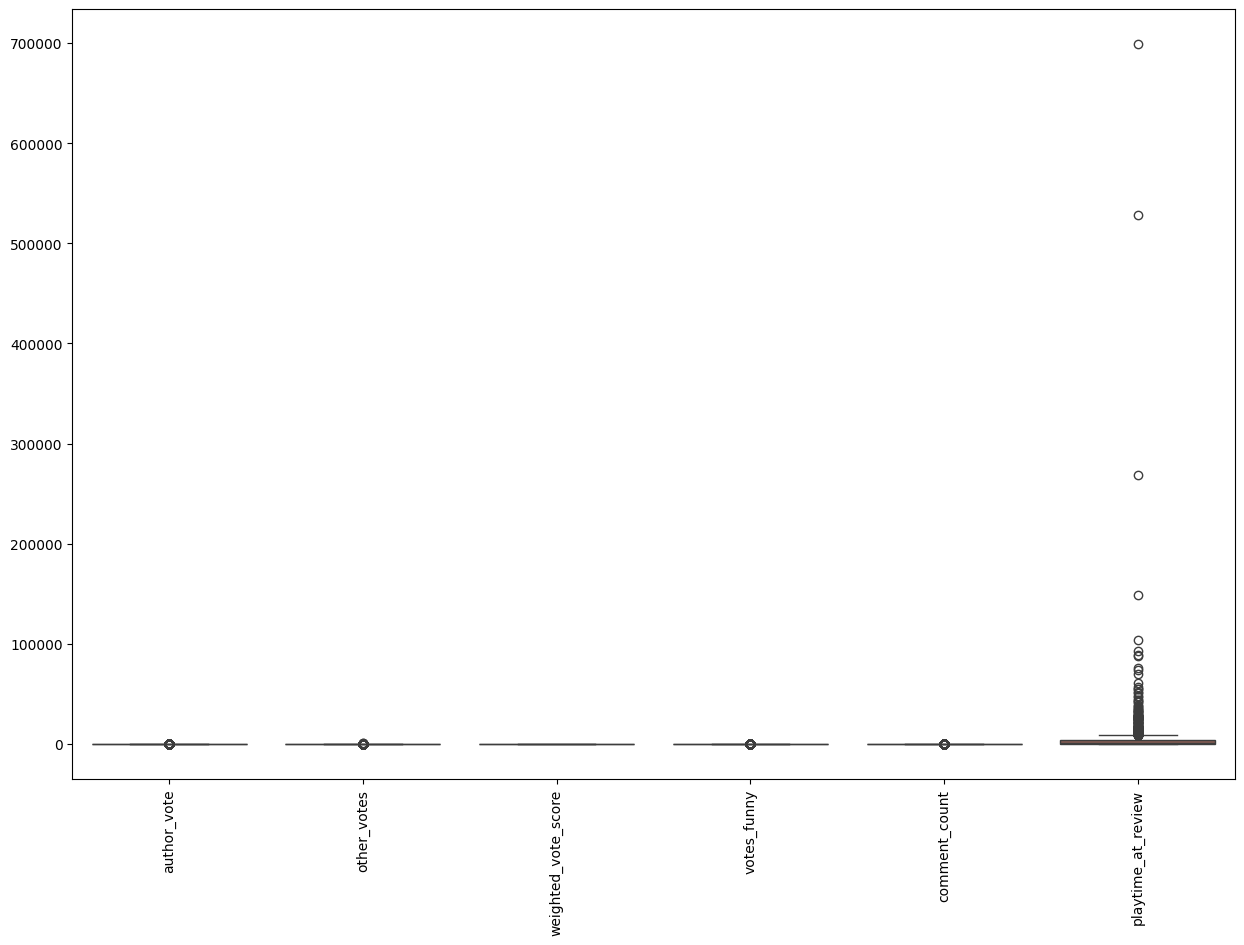

In [12]:
# Distribution of Numerical Variables
# Visualize the distribution of numerical variables using histograms and boxplots.
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram for numerical columns
df.hist(bins=30, figsize=(15, 10))
plt.show()

# Boxplot for numerical columns
plt.figure(figsize=(15, 10))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.show()